In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'segnet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 813.21it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
        
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:08<00:00, 41.76img/s]

***
segnet Loss: 0.9876495599746704


Epoch 1/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.10img/s]


---
segnet Validation Dice Loss: 1.0194916725158691
segnet Validation Pixel Accuracy: 0.7386062354372259
segnet Validation MIoU: 0.42720924095790747
segnet Validation Dice Score: 0.238761767745018


Epoch 2/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.20img/s]

***
segnet Loss: 0.5761405229568481


Epoch 2/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.53img/s]


---
segnet Validation Dice Loss: 0.6054103374481201
segnet Validation Pixel Accuracy: 0.85203498706483
segnet Validation MIoU: 0.4432471954988918
segnet Validation Dice Score: 0.07061883807182312


Epoch 3/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.84img/s]

***
segnet Loss: 0.34496474266052246


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.57img/s]


---
segnet Validation Dice Loss: 0.3848648965358734
segnet Validation Pixel Accuracy: 0.9162056906181469
segnet Validation MIoU: 0.7557042426615086
segnet Validation Dice Score: 0.7725550532341003


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.50img/s]

***
segnet Loss: 0.3025142252445221


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.52img/s]


---
segnet Validation Dice Loss: 0.30236130952835083
segnet Validation Pixel Accuracy: 0.9253331234580592
segnet Validation MIoU: 0.7708608604234887
segnet Validation Dice Score: 0.7892245650291443


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.54img/s]

***
segnet Loss: 0.19745862483978271


Epoch 5/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.35img/s]


---
segnet Validation Dice Loss: 0.2501298785209656
segnet Validation Pixel Accuracy: 0.9403044048108553
segnet Validation MIoU: 0.8139099932571017
segnet Validation Dice Score: 0.8328470587730408


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.40img/s]

***
segnet Loss: 0.20189602673053741


Epoch 6/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.24img/s]


---
segnet Validation Dice Loss: 0.23941314220428467
segnet Validation Pixel Accuracy: 0.94012451171875
segnet Validation MIoU: 0.8056832771201232
segnet Validation Dice Score: 0.8188062906265259


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.27img/s]

***
segnet Loss: 0.16905257105827332


Epoch 7/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.21438230574131012
segnet Validation Pixel Accuracy: 0.944716871830455
segnet Validation MIoU: 0.8199888050726972
segnet Validation Dice Score: 0.8338999152183533


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.62img/s]

***
segnet Loss: 0.13254176080226898


Epoch 8/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.44img/s]


---
segnet Validation Dice Loss: 0.22129644453525543
segnet Validation Pixel Accuracy: 0.9424299273574561
segnet Validation MIoU: 0.8098329318505428
segnet Validation Dice Score: 0.8581066131591797


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.17img/s]

***
segnet Loss: 0.12685279548168182


Epoch 9/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.79img/s]


---
segnet Validation Dice Loss: 0.22729437053203583
segnet Validation Pixel Accuracy: 0.9438385545161733
segnet Validation MIoU: 0.8107427600619185
segnet Validation Dice Score: 0.8578238487243652


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.99img/s]

***
segnet Loss: 0.19160611927509308


Epoch 10/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
segnet Validation Dice Loss: 0.2819136381149292
segnet Validation Pixel Accuracy: 0.9294302421703673
segnet Validation MIoU: 0.7927798817705836
segnet Validation Dice Score: 0.8428528904914856


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.42img/s]

***
segnet Loss: 0.11795924603939056


Epoch 11/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.23img/s]


---
segnet Validation Dice Loss: 0.1688724011182785
segnet Validation Pixel Accuracy: 0.9567951403166118
segnet Validation MIoU: 0.854661348657128
segnet Validation Dice Score: 0.8454102873802185


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.24img/s]

***
segnet Loss: 0.10498318821191788


Epoch 12/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.47img/s]


---
segnet Validation Dice Loss: 0.15469646453857422
segnet Validation Pixel Accuracy: 0.9611189992804277
segnet Validation MIoU: 0.8663781459232573
segnet Validation Dice Score: 0.8974606394767761


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.43img/s]

***
segnet Loss: 0.11346472054719925


Epoch 13/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.10img/s]


---
segnet Validation Dice Loss: 0.1595807522535324
segnet Validation Pixel Accuracy: 0.9597371419270834
segnet Validation MIoU: 0.8636355421157375
segnet Validation Dice Score: 0.8933135271072388


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.24img/s]

***
segnet Loss: 0.08036616444587708


Epoch 14/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.32img/s]


---
segnet Validation Dice Loss: 0.1774330586194992
segnet Validation Pixel Accuracy: 0.955776013826069
segnet Validation MIoU: 0.8521775888637187
segnet Validation Dice Score: 0.8972880244255066


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.29img/s]

***
segnet Loss: 0.09928317368030548


Epoch 15/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.87img/s]


---
segnet Validation Dice Loss: 0.15467675030231476
segnet Validation Pixel Accuracy: 0.9612836335834704
segnet Validation MIoU: 0.8667658085535573
segnet Validation Dice Score: 0.9036590456962585


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.89img/s]

***
segnet Loss: 0.12085743248462677


Epoch 16/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.19img/s]


---
segnet Validation Dice Loss: 0.1501951962709427
segnet Validation Pixel Accuracy: 0.9629728083024945
segnet Validation MIoU: 0.8733418187426005
segnet Validation Dice Score: 0.8949476480484009


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.20img/s]

***
segnet Loss: 0.06717585027217865


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.90img/s]


---
segnet Validation Dice Loss: 0.15888218581676483
segnet Validation Pixel Accuracy: 0.9615395529228344
segnet Validation MIoU: 0.8702350236939427
segnet Validation Dice Score: 0.8966568112373352


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.71img/s]

***
segnet Loss: 0.09123344719409943


Epoch 18/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
segnet Validation Dice Loss: 0.17543841898441315
segnet Validation Pixel Accuracy: 0.9576298228481359
segnet Validation MIoU: 0.8593060760172492
segnet Validation Dice Score: 0.9049755930900574


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.21img/s]

***
segnet Loss: 0.09247823059558868


Epoch 19/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.39img/s]


---
segnet Validation Dice Loss: 0.1523139327764511
segnet Validation Pixel Accuracy: 0.9623635275322094
segnet Validation MIoU: 0.8693957894863349
segnet Validation Dice Score: 0.9080309867858887


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.10img/s]

***
segnet Loss: 0.10936035960912704


Epoch 20/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.22img/s]


---
segnet Validation Dice Loss: 0.16262365877628326
segnet Validation Pixel Accuracy: 0.9603836327268366
segnet Validation MIoU: 0.8674102966397657
segnet Validation Dice Score: 0.9005290269851685


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.15img/s]

***
segnet Loss: 0.0720481127500534


Epoch 21/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.15258747339248657
segnet Validation Pixel Accuracy: 0.9622071918688322
segnet Validation MIoU: 0.8722272838198681
segnet Validation Dice Score: 0.9058117866516113


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.03img/s]

***
segnet Loss: 0.06291167438030243


Epoch 22/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.22img/s]


---
segnet Validation Dice Loss: 0.15149161219596863
segnet Validation Pixel Accuracy: 0.9625760797868695
segnet Validation MIoU: 0.8702268944739937
segnet Validation Dice Score: 0.9087939262390137


Epoch 23/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.09img/s]

***
segnet Loss: 0.05774199217557907


Epoch 23/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.07img/s]


---
segnet Validation Dice Loss: 0.14610348641872406
segnet Validation Pixel Accuracy: 0.9634335166529605
segnet Validation MIoU: 0.8713672235234111
segnet Validation Dice Score: 0.9057302474975586


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.13img/s]

***
segnet Loss: 0.08172431588172913


Epoch 24/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.40img/s]


---
segnet Validation Dice Loss: 0.14044898748397827
segnet Validation Pixel Accuracy: 0.9658663565652412
segnet Validation MIoU: 0.8825657147959113
segnet Validation Dice Score: 0.9041153192520142


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.12img/s]

***
segnet Loss: 0.062343548983335495


Epoch 25/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.11img/s]


---
segnet Validation Dice Loss: 0.14278548955917358
segnet Validation Pixel Accuracy: 0.9652295028954222
segnet Validation MIoU: 0.8774814224154892
segnet Validation Dice Score: 0.9044820666313171


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.28img/s]

***
segnet Loss: 0.0541500486433506


Epoch 26/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.89img/s]


---
segnet Validation Dice Loss: 0.145416259765625
segnet Validation Pixel Accuracy: 0.9638832493832237
segnet Validation MIoU: 0.873955452561615
segnet Validation Dice Score: 0.9085131883621216


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.14img/s]

***
segnet Loss: 0.04758083075284958


Epoch 27/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.99img/s]


---
segnet Validation Dice Loss: 0.14864613115787506
segnet Validation Pixel Accuracy: 0.963467514305784
segnet Validation MIoU: 0.8740494445948468
segnet Validation Dice Score: 0.9065079689025879


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.03img/s]

***
segnet Loss: 0.059310585260391235


Epoch 28/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.89img/s]


---
segnet Validation Dice Loss: 0.15550950169563293
segnet Validation Pixel Accuracy: 0.9621167099266722
segnet Validation MIoU: 0.8703869293266
segnet Validation Dice Score: 0.9063877463340759


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.98img/s]

***
segnet Loss: 0.05583950877189636


Epoch 29/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.83img/s]


---
segnet Validation Dice Loss: 0.15389035642147064
segnet Validation Pixel Accuracy: 0.9624534740782621
segnet Validation MIoU: 0.8721505417673696
segnet Validation Dice Score: 0.9045931100845337


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.91img/s]

***
segnet Loss: 0.0510777123272419


Epoch 30/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.97img/s]


---
segnet Validation Dice Loss: 0.14644953608512878
segnet Validation Pixel Accuracy: 0.96495002612733
segnet Validation MIoU: 0.8800380922334321
segnet Validation Dice Score: 0.9065228700637817


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.93img/s]

***
segnet Loss: 0.06143983080983162


Epoch 31/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.02img/s]


---
segnet Validation Dice Loss: 0.14252644777297974
segnet Validation Pixel Accuracy: 0.965427599455181
segnet Validation MIoU: 0.8806468284616911
segnet Validation Dice Score: 0.9103607535362244


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.77img/s]

***
segnet Loss: 0.0676451325416565


Epoch 32/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.59img/s]


---
segnet Validation Dice Loss: 0.16029271483421326
segnet Validation Pixel Accuracy: 0.9615631103515625
segnet Validation MIoU: 0.8703395162062904
segnet Validation Dice Score: 0.9083669781684875


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.93img/s]

***
segnet Loss: 0.055721770972013474


Epoch 33/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
segnet Validation Dice Loss: 0.1372469663619995
segnet Validation Pixel Accuracy: 0.9664756373355263
segnet Validation MIoU: 0.8835851975648483
segnet Validation Dice Score: 0.9049462676048279


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.17img/s]

***
segnet Loss: 0.0583752766251564


Epoch 34/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.04img/s]


---
segnet Validation Dice Loss: 0.1462508738040924
segnet Validation Pixel Accuracy: 0.9648124293277138
segnet Validation MIoU: 0.8794080609978665
segnet Validation Dice Score: 0.908771812915802


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.34img/s]

***
segnet Loss: 0.051135387271642685


Epoch 35/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
segnet Validation Dice Loss: 0.1359715461730957
segnet Validation Pixel Accuracy: 0.967245804636102
segnet Validation MIoU: 0.8856933743390707
segnet Validation Dice Score: 0.9092170000076294


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.54img/s]

***
segnet Loss: 0.06622936576604843


Epoch 36/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.83img/s]


---
segnet Validation Dice Loss: 0.12995296716690063
segnet Validation Pixel Accuracy: 0.9684847112287555
segnet Validation MIoU: 0.887078306576822
segnet Validation Dice Score: 0.909224808216095


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.19img/s]

***
segnet Loss: 0.07201369851827621


Epoch 37/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.59img/s]


---
segnet Validation Dice Loss: 0.136766254901886
segnet Validation Pixel Accuracy: 0.9661969636615954
segnet Validation MIoU: 0.8809980248624916
segnet Validation Dice Score: 0.9111136794090271


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.68img/s]

***
segnet Loss: 0.06322381645441055


Epoch 38/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.27img/s]


---
segnet Validation Dice Loss: 0.13828060030937195
segnet Validation Pixel Accuracy: 0.9659418474163926
segnet Validation MIoU: 0.881208100532656
segnet Validation Dice Score: 0.9062991142272949


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.54img/s]

***
segnet Loss: 0.0625440925359726


Epoch 39/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.13img/s]


---
segnet Validation Dice Loss: 0.1566186249256134
segnet Validation Pixel Accuracy: 0.9628973174513432
segnet Validation MIoU: 0.8743662518350923
segnet Validation Dice Score: 0.9069035649299622


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.00img/s]

***
segnet Loss: 0.04697997868061066


Epoch 40/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.06img/s]


---
segnet Validation Dice Loss: 0.14325496554374695
segnet Validation Pixel Accuracy: 0.9650852136444628
segnet Validation MIoU: 0.8791090653838747
segnet Validation Dice Score: 0.9089946150779724


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.01img/s]

***
segnet Loss: 0.05519602447748184


Epoch 41/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.02img/s]


---
segnet Validation Dice Loss: 0.1420610100030899
segnet Validation Pixel Accuracy: 0.9654856899328399
segnet Validation MIoU: 0.8803294294593756
segnet Validation Dice Score: 0.9113611578941345


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.23img/s]

***
segnet Loss: 0.05334682762622833


Epoch 42/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.31img/s]


---
segnet Validation Dice Loss: 0.14164716005325317
segnet Validation Pixel Accuracy: 0.9655419065241229
segnet Validation MIoU: 0.8806513529195614
segnet Validation Dice Score: 0.9113168716430664


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.05img/s]

***
segnet Loss: 0.05239938944578171


Epoch 43/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.53img/s]


---
segnet Validation Dice Loss: 0.1453377604484558
segnet Validation Pixel Accuracy: 0.9648169801946271
segnet Validation MIoU: 0.8785005547802884
segnet Validation Dice Score: 0.9114185571670532


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.32img/s]

***
segnet Loss: 0.05538809671998024


Epoch 44/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.66img/s]


---
segnet Validation Dice Loss: 0.1434536576271057
segnet Validation Pixel Accuracy: 0.9646269145764803
segnet Validation MIoU: 0.8770017154379648
segnet Validation Dice Score: 0.9122077226638794


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.91img/s]

***
segnet Loss: 0.058255892246961594


Epoch 45/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.24img/s]


---
segnet Validation Dice Loss: 0.14728789031505585
segnet Validation Pixel Accuracy: 0.9634830407929003
segnet Validation MIoU: 0.8732382277013597
segnet Validation Dice Score: 0.9049771428108215


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.10img/s]

***
segnet Loss: 0.06525631994009018


Epoch 46/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.75img/s]


---
segnet Validation Dice Loss: 0.14819125831127167
segnet Validation Pixel Accuracy: 0.9652329829701206
segnet Validation MIoU: 0.8811668940251891
segnet Validation Dice Score: 0.9055652022361755


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.98img/s]

***
segnet Loss: 0.0607827827334404


Epoch 47/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.71img/s]


---
segnet Validation Dice Loss: 0.13086891174316406
segnet Validation Pixel Accuracy: 0.9684215344880757
segnet Validation MIoU: 0.889233797262829
segnet Validation Dice Score: 0.9088201522827148


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.92img/s]

***
segnet Loss: 0.07458578050136566


Epoch 48/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.92img/s]


---
segnet Validation Dice Loss: 0.13048160076141357
segnet Validation Pixel Accuracy: 0.9683275724712171
segnet Validation MIoU: 0.8882964353788372
segnet Validation Dice Score: 0.9069942831993103


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.28img/s]

***
segnet Loss: 0.06077515706419945


Epoch 49/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.20img/s]


---
segnet Validation Dice Loss: 0.15873955190181732
segnet Validation Pixel Accuracy: 0.9613446687397204
segnet Validation MIoU: 0.8686276754589619
segnet Validation Dice Score: 0.9035800099372864


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.22img/s]

***
segnet Loss: 0.059652987867593765


Epoch 50/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.33img/s]

---
segnet Validation Dice Loss: 0.13167627155780792
segnet Validation Pixel Accuracy: 0.9685318260862116
segnet Validation MIoU: 0.8888652671700209
segnet Validation Dice Score: 0.903187096118927


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

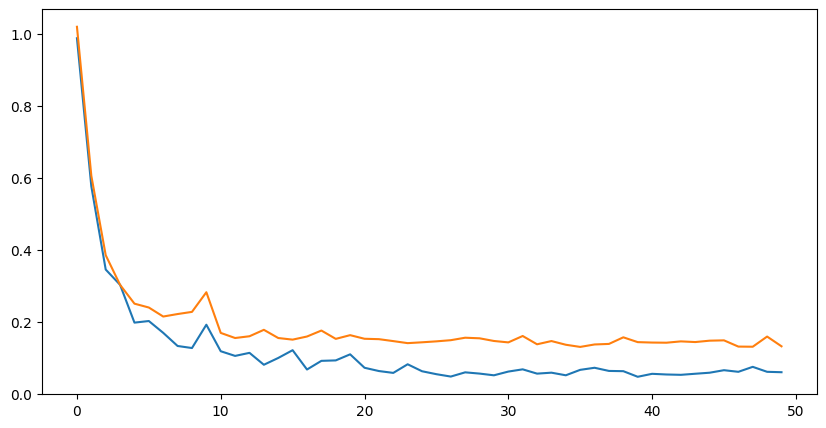

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

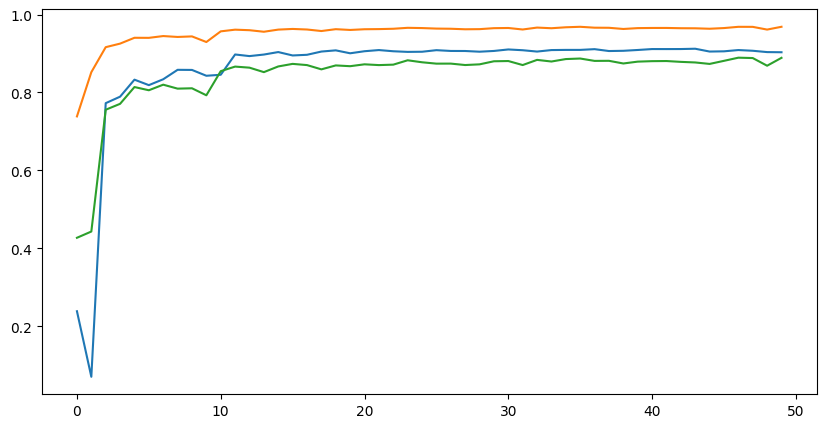

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)